# Práctica de Detección de Rostros Reales y Falsos con Redes Neuronales Convolucionales (CNN) en PyTorch

**Objetivo:** Desarrollar un modelo de clasificación basado en una CNN para distinguir entre imágenes de rostros reales y falsificados por expertos.

**Introducción:** 
En la era digital, el uso de imágenes falsificadas ha ido en aumento, especialmente en las redes sociales. La identificación de estas imágenes es crucial para garantizar la autenticidad de la información. Aunque existen modelos generativos como las GANs que pueden producir rostros falsos, los falsificadores humanos utilizan técnicas distintas que a menudo desafían a los modelos automáticos.

**Datos:**
Se proporciona un conjunto de datos que contiene imágenes de rostros, tanto reales como modificadas por expertos. Las imágenes falsificadas se dividen en tres categorías según su dificultad de detección: fácil, medio y difícil. [Enlace al conjunto de datos](https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection).

**Instrucciones:**

1. **Preprocesamiento de Datos:**
   - Descarga y descomprime el conjunto de datos.
   - Divide los datos en conjuntos de entrenamiento y prueba.
   - Normaliza las imágenes y conviértelas en tensores.

2. **Construcción del Modelo:**
   - Diseña una CNN para clasificar imágenes de rostros reales y falsificados.
   - Añade capas totalmente conectadas al final para la clasificación.

3. **Entrenamiento:**
   - Define una función de pérdida y un optimizador.
   - Entrena el modelo usando el conjunto de entrenamiento.
   - Evalúa el rendimiento del modelo en el conjunto de prueba tras cada época.

4. **Evaluación:**
   - Utiliza el Accuracy para evaluar el rendimiento del modelo.
   - Visualiza algunas predicciones del modelo para entender sus aciertos y errores.

5. **Conclusión:**
   - Discute los resultados obtenidos.
   - Sugerencias para mejorar el rendimiento del modelo.

6. **Extras:**
   - Explora diferentes arquitecturas de CNN.
   - Usas otras métricas de evaluación (F1, Precision, Recall, etc.)
   - Utiliza técnicas de aumento de datos para mejorar el rendimiento del modelo.
   - Buscar otros conjuntos de datos extras para entrenar el modelo.
   - Utiliza técnicas de regularización para evitar el sobreajuste del modelo.
   - Transfer Learning: Utiliza un modelo pre-entrenado para mejorar el rendimiento del modelo.
   - Usar otras liberias de Deep Learning como pytorch-lightning o wandb
   - Usar liberias de optimización como optuna, etc.
   - ...

7. **Competición:**
   - Un punto extra se otorgará a los 3 mejores modelos de la clase.
   - Gana el modelo que obtenga el Accuracy más alto en un conjunto de datos de prueba oculto, que ya os pasaré
   - No uses ese conjunto de datos para entrenar tu modelo, solo para evaluarlo al final !!

**Entregables:**
- Código fuente en Python del modelo.
- Un informe detallando el diseño del modelo, resultados, conclusiones y recomendaciones.
- **Lo quiero todo subido a un repositorio en GitHub.**

**Kaggle**  
https://www.kaggle.com/datasets/ciplab/real-and-fake-face-detection/code?datasetId=105271&sortBy=voteCount
https://www.kaggle.com/code/tusharpadhy/real-fake-face-classification-and-visualization/notebook

https://debuggercafe.com/pytorch-imagefolder-for-training-cnn-models/  
https://medium.com/thecyphy/train-cnn-model-with-pytorch-21dafb918f48

In [65]:
# --- pytorch

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets
import torchvision.utils as vutils
from torchsummary import summary

# --- otras

import matplotlib.pyplot as plt
import numpy as np
import os
import cv2

#da MNIST
import torch.nn.functional as F

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Usando {device} para entrenar')

Usando cpu para entrenar


In [4]:
DATASET = 'real_and_fake_face' # esto puede cambiar dependiendo de donde se ejecute el notebook
INITIAL_SIZE_OF_IMAGES = (128, 128)

# Explora Sample Images de Dataset

In [5]:
# IMAGE SAMPLE
# https://www.kaggle.com/code/tusharpadhy/real-fake-face-classification-and-visualization/notebook

def load_img(path):
    '''Loading images from directory
    and changing color space from cv2 standard BGR to RGB
    for better visualization'''
    image = cv2.imread(path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image_rgb

real_and_fake_face/training_real/real_01039.jpg


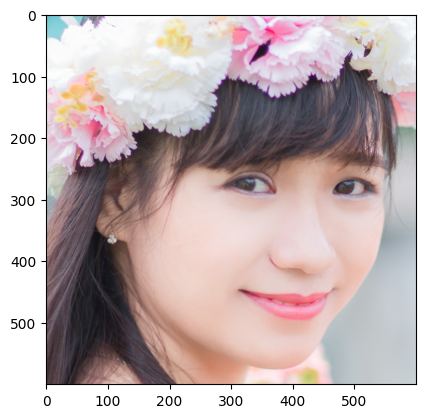

In [6]:
real_dir = os.path.join(DATASET,'training_real')
real_path = os.listdir(real_dir)
#print(real_path)
print(real_dir + '/' + real_path[0])
plt.figure()
plt.imshow(load_img(real_dir + '/' + real_path[15]))
plt.show()

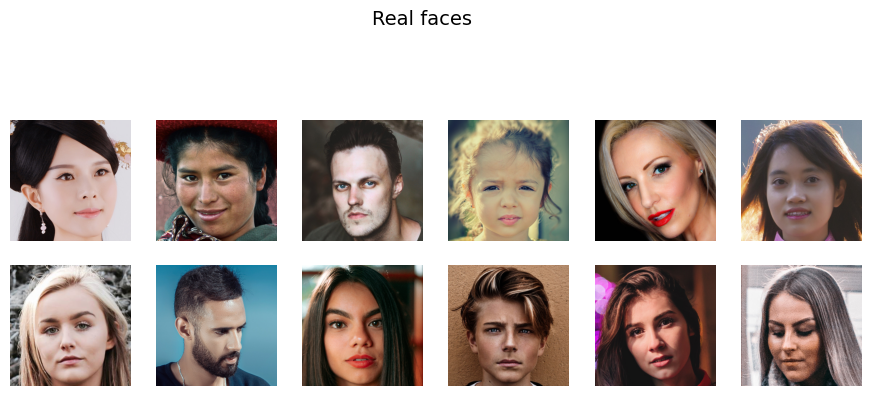

In [7]:
fig = plt.figure(figsize=(11, 11))

for i in range(12):
    plt.subplot(6, 6, i+1)
    plt.imshow(load_img(real_dir + '/' +  real_path[i]))
    plt.suptitle("Real faces", fontsize=14)
    plt.axis('off')

# Divide los datos en conjuntos de entrenamiento y prueba.

In [8]:
#transforma size de imagenes, convierte en tensor, normaliza
data_transforms = transforms.Compose([
    transforms.Resize(INITIAL_SIZE_OF_IMAGES),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [9]:
# Dividir el conjunto de entrenamiento en entrenamiento y validación
#carga datos
full_dataset = datasets.ImageFolder(root=DATASET, transform=data_transforms)
print(full_dataset)

#train, test y validation
train_size = int(0.8 * len(full_dataset)) # 80% para entrenamiento
test_size = int(0.1 * len(full_dataset)) # 10% test
valid_size = len(full_dataset) - (train_size+test_size) #100-(80+10) = c.ca 10% para validación

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, valid_size,test_size])

#dataloader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=100, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=100, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=100, shuffle=False)

print(len(train_dataset[0][0]))
print(train_dataset[0][1])   #label

Dataset ImageFolder
    Number of datapoints: 2041
    Root location: real_and_fake_face
    StandardTransform
Transform: Compose(
               Resize(size=(128, 128), interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
           )
3
1


In [10]:
#print(train_loader[0])
print(train_size)
print(valid_size)
print(test_size)

1632
205
204


# Model 1

In [ ]:
#RAFF = Real And Fake Faces

class RAFF_CNN(nn.Module):
    def __init__(self):
        super(RAFF_CNN, self).__init__()

        # Primera capa convolucional: 1 canal de entrada (escala de grises),
        # 32 canales de salida, kernel de 3x3, padding de 1 para mantener el tamaño
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)

        # Segunda capa convolucional: 32 canales de entrada, 64 canales de salida
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)


        # Capa de pooling: reduce a la mitad el tamaño de la imagen
        self.pool = nn.MaxPool2d(2, 2)


        # Capa fully-conected: la imagen es 7x7 después de dos pooling,
        # y 64 canales, así que 7*7*64 entradas y, por ejemplo, 128 salidas
        self.fc1 = nn.Linear(32*32*64, 128)

        # Capa completamente conectada final: 128 entradas y 2 salidas (clases del 0 al 1, masculino-feminino-fake-real)
        self.fc2 = nn.Linear(128, 2)

        # Capa de dropout para reducir el overfitting
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        # Pasar x a través de las capas convolucionales y las funciones de activación ReLU
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))

        # Aplanar la imagen para la capa completamente conectada
        x = x.view(-1, 32*32*64)

        # Pasar a través de las capas completamente conectadas con ReLU y dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)  # No se usa activación aquí porque se usará nn.CrossEntropyLoss()

        return x

In [ ]:
# Crear una instancia de la red
model = RAFF_CNN().to(device)
print(model)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

RAFF_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=65536, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
# Crea un'istanza del modello
#model = RAFF_CNN()

# Stampa un riepilogo del modello
summary(model, (3, 256, 256))  # Input shape: (canali, altezza, larghezza)
#(3, 256, 256)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             896
         MaxPool2d-2         [-1, 32, 128, 128]               0
            Conv2d-3         [-1, 64, 128, 128]          18,496
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Linear-5                  [-1, 128]       8,388,736
           Dropout-6                  [-1, 128]               0
            Linear-7                    [-1, 2]             258
Total params: 8,408,386
Trainable params: 8,408,386
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 30.00
Params size (MB): 32.08
Estimated Total Size (MB): 62.83
----------------------------------------------------------------


## Training 1


In [ ]:
num_epochs = 10

train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    training_loss = 0.0
    correct_train = 0
    total_train = 0
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)
    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

    model.train()

print("Entrenamiento finalizado!")

Epoch [1/10], Train Loss: 0.9628, Train Acc: 51.90%, Valid Loss: 0.6900, Valid Acc: 53.17%
Epoch [2/10], Train Loss: 0.6915, Train Acc: 53.12%, Valid Loss: 0.6892, Valid Acc: 53.17%
Epoch [3/10], Train Loss: 0.6862, Train Acc: 56.31%, Valid Loss: 0.6745, Valid Acc: 53.66%
Epoch [4/10], Train Loss: 0.6692, Train Acc: 59.38%, Valid Loss: 0.7005, Valid Acc: 51.22%
Epoch [5/10], Train Loss: 0.6482, Train Acc: 63.24%, Valid Loss: 0.6694, Valid Acc: 57.07%
Epoch [6/10], Train Loss: 0.6286, Train Acc: 65.87%, Valid Loss: 0.6545, Valid Acc: 56.10%
Epoch [7/10], Train Loss: 0.6045, Train Acc: 68.75%, Valid Loss: 0.6647, Valid Acc: 58.54%
Epoch [8/10], Train Loss: 0.5881, Train Acc: 68.38%, Valid Loss: 0.6423, Valid Acc: 58.54%
Epoch [9/10], Train Loss: 0.5625, Train Acc: 72.00%, Valid Loss: 0.6648, Valid Acc: 55.61%
Epoch [10/10], Train Loss: 0.5295, Train Acc: 72.86%, Valid Loss: 0.6609, Valid Acc: 56.59%
Entrenamiento finalizado!


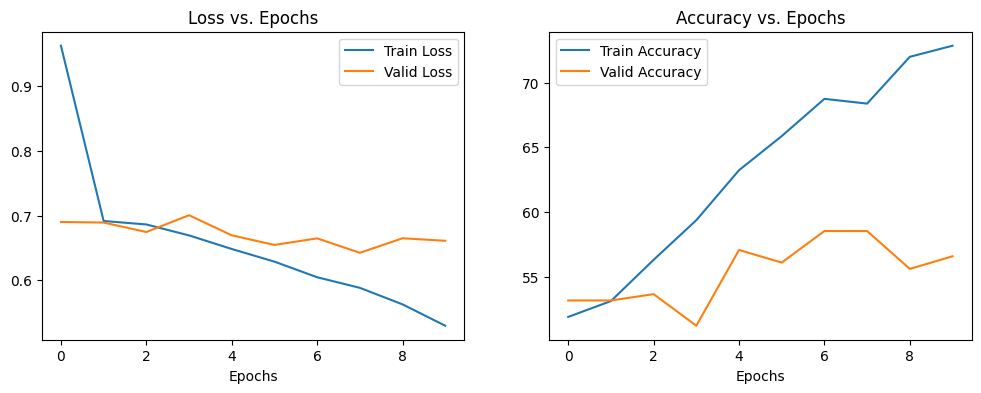

In [ ]:
# Graficar accuracy y loss

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(valid_losses, label='Valid Loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Accuracy vs. Epochs')

plt.show()

In [ ]:
model.eval()
with torch.no_grad(): # Deshabilita el cálculo de gradientes
    correct = 0
    total = 0
    for images, labels in test_loader:
        # pasar al dispositivo
        images = images.to(device)
        labels = labels.to(device)
        ############################
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # Obtiene el índice de la clase con mayor probabilidad
        total += labels.size(0) # Tamaño del batch
        correct += (predicted == labels).sum().item() # Suma el número de predicciones correctas

    print(f'Precisión del modelo en las ... imágenes de prueba: {100 * correct / total}%')

Precisión del modelo en las ... imágenes de prueba: 56.86274509803921%


In [ ]:
# Matriz de confusión
import sklearn.metrics as metrics
import numpy as np

y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

print('Confusion Matrix')
print(metrics.confusion_matrix(y_true, y_pred))

Confusion Matrix
[[59 41]
 [47 57]]


In [ ]:
# Metricas
print('Classification Report')
print(metrics.classification_report(y_true, y_pred, target_names=full_dataset.classes))

Classification Report
               precision    recall  f1-score   support

training_fake       0.56      0.59      0.57       100
training_real       0.58      0.55      0.56       104

     accuracy                           0.57       204
    macro avg       0.57      0.57      0.57       204
 weighted avg       0.57      0.57      0.57       204



# Model 2

In [66]:
#RAFF2 = Real And Fake Faces 2, con mas capas conv

class RAFF2_CNN(nn.Module):
    def __init__(self):
        super(RAFF2_CNN, self).__init__()

        # Primera capa convolucional: 3 canales de entrada (rgb),
        # 64 canales de salida, kernel de 3x3, padding de 1 para mantener el tamaño
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)

        # Segunda capa convolucional: 64 canales de entrada, 128 canales de salida
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)


        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv4 = nn.Conv2d(128, 256, 3, padding=1)


        self.pool = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(256 * 32 * 32, 512) # Supponendo che l'output della convoluzione sia 16x16 con 256 canali
        #self.fc1 = nn.Linear(256 * 8 * 8, 512)

        self.fc2 = nn.Linear(512, 2)

        # Capa de dropout para reducir el overfitting
        self.dropout = nn.Dropout(0.5)


    def forward(self, x):
        #print(x.shape)
        # Pasar x a través de las capas convolucionales y las funciones de activación ReLU

        #x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv1(x))             # non faccio il max pooling
        x = self.pool(F.relu(self.conv2(x)))
        #x = self.pool(F.relu(self.conv3(x)))
        x = F.relu(self.conv3(x))
        x = self.pool(self.dropout(F.relu(self.conv4(x))))
        #print(x.shape)

        # Aplanar la imagen para la capa completamente conectada
        x = x.view(-1, 32*32*256)

        # Pasar a través de las capas completamente conectadas con ReLU y dropout
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)  # No se usa activación aquí porque se usará nn.CrossEntropyLoss()
        #print(x.shape)
        return x

In [67]:
# Crear una instancia de la red
model2 = RAFF2_CNN().to(device)
print(model2)
#criterion = nn.CrossEntropyLoss().to(device)
#optimizer = optim.Adam(model2.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model2.parameters(), lr=1)


RAFF2_CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=262144, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [68]:
# Crea un'istanza del modello
#model2 = RAFF2_CNN()
#model2 = model2.to(device)

# Stampa un riepilogo del modello
summary(model2, (3, 256, 256))  # Input shape: (canali, altezza, larghezza)

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 256, 256]        896
├─Conv2d: 1-2                            [-1, 64, 256, 256]        18,496
├─MaxPool2d: 1-3                         [-1, 64, 128, 128]        --
├─Conv2d: 1-4                            [-1, 128, 128, 128]       73,856
├─Conv2d: 1-5                            [-1, 256, 128, 128]       295,168
├─Dropout: 1-6                           [-1, 256, 128, 128]       --
├─MaxPool2d: 1-7                         [-1, 256, 64, 64]         --
├─Linear: 1-8                            [-1, 512]                 134,218,240
├─Dropout: 1-9                           [-1, 512]                 --
├─Linear: 1-10                           [-1, 2]                   1,026
Total params: 134,607,682
Trainable params: 134,607,682
Non-trainable params: 0
Total mult-adds (G): 7.44
Input size (MB): 0.75
Forward/backward pass size (MB): 96.00
Params size (MB): 513.49
Estimat

Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 256, 256]        896
├─Conv2d: 1-2                            [-1, 64, 256, 256]        18,496
├─MaxPool2d: 1-3                         [-1, 64, 128, 128]        --
├─Conv2d: 1-4                            [-1, 128, 128, 128]       73,856
├─Conv2d: 1-5                            [-1, 256, 128, 128]       295,168
├─Dropout: 1-6                           [-1, 256, 128, 128]       --
├─MaxPool2d: 1-7                         [-1, 256, 64, 64]         --
├─Linear: 1-8                            [-1, 512]                 134,218,240
├─Dropout: 1-9                           [-1, 512]                 --
├─Linear: 1-10                           [-1, 2]                   1,026
Total params: 134,607,682
Trainable params: 134,607,682
Non-trainable params: 0
Total mult-adds (G): 7.44
Input size (MB): 0.75
Forward/backward pass size (MB): 96.00
Params size (MB): 513.49
Estimat

# Training 2

In [ ]:
num_epochs = 30

train_losses = []
avg_train_losses = []
valid_losses = []
avg_valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    training_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        #print(images)
        labels = labels.to(device)
        #print(labels)

        outputs = model2(images)
        #print(outputs)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(training_loss)
    avg_train_losses.append(avg_train_loss)

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model2.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model2(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(valid_loss)
    avg_valid_losses.append(avg_valid_loss)

    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}],  Train Loss: {training_loss:.4f}, Avg Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Valid Loss: {valid_loss:.4f} ,Avg Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

    model2.train()

print("Entrenamiento finalizado!")

Epoch [1/30],  Train Loss: 12.3047, Avg Train Loss: 0.7238, Train Acc: 52.02%, Valid Loss: 2.0814 ,Avg Valid Loss: 0.6938, Valid Acc: 49.76%
Epoch [2/30],  Train Loss: 11.7773, Avg Train Loss: 0.6928, Train Acc: 51.04%, Valid Loss: 2.0792 ,Avg Valid Loss: 0.6931, Valid Acc: 52.20%
Epoch [3/30],  Train Loss: 11.7643, Avg Train Loss: 0.6920, Train Acc: 55.27%, Valid Loss: 2.0779 ,Avg Valid Loss: 0.6926, Valid Acc: 56.10%
Epoch [4/30],  Train Loss: 11.9191, Avg Train Loss: 0.7011, Train Acc: 51.65%, Valid Loss: 2.0621 ,Avg Valid Loss: 0.6874, Valid Acc: 50.24%
Epoch [5/30],  Train Loss: 11.7049, Avg Train Loss: 0.6885, Train Acc: 55.88%, Valid Loss: 2.0549 ,Avg Valid Loss: 0.6850, Valid Acc: 48.29%
Epoch [6/30],  Train Loss: 11.5712, Avg Train Loss: 0.6807, Train Acc: 58.82%, Valid Loss: 2.0156 ,Avg Valid Loss: 0.6719, Valid Acc: 49.76%
Epoch [7/30],  Train Loss: 11.3607, Avg Train Loss: 0.6683, Train Acc: 58.27%, Valid Loss: 2.7594 ,Avg Valid Loss: 0.9198, Valid Acc: 50.24%
Epoch [8/30],

# Evaluation

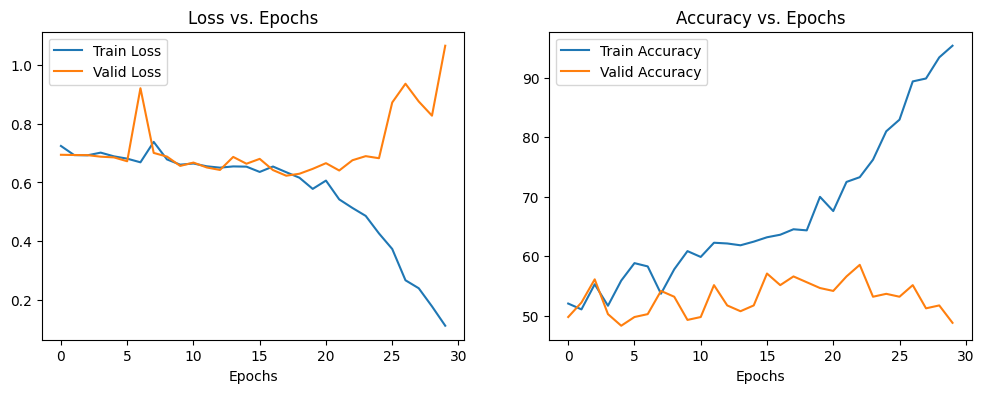

In [ ]:
# Graficar el accuracy y el loss

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_train_losses, label='Train Loss')
plt.plot(avg_valid_losses, label='Valid Loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Accuracy vs. Epochs')

plt.show()

In [ ]:
model.eval()
with torch.no_grad(): # Deshabilita el cálculo de gradientes
    correct = 0
    total = 0
    for images, labels in test_loader:
        # pasar al dispositivo
        images = images.to(device)
        labels = labels.to(device)
        ############################
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # Obtiene el índice de la clase con mayor probabilidad
        total += labels.size(0) # Tamaño del batch
        correct += (predicted == labels).sum().item() # Suma el número de predicciones correctas

    print(f'Precisión del modelo en las ... imágenes de prueba: {100 * correct / total}%')

Precisión del modelo en las ... imágenes de prueba: 56.86274509803921%


In [ ]:
# Matriz de confusión
import sklearn.metrics as metrics
import numpy as np

y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model2(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

print('Confusion Matrix')
print(metrics.confusion_matrix(y_true, y_pred))

Confusion Matrix
[[39 50]
 [25 90]]


In [ ]:
# Metricas
print('Classification Report')
print(metrics.classification_report(y_true, y_pred, target_names=full_dataset.classes))

Classification Report
               precision    recall  f1-score   support

training_fake       0.61      0.44      0.51        89
training_real       0.64      0.78      0.71       115

     accuracy                           0.63       204
    macro avg       0.63      0.61      0.61       204
 weighted avg       0.63      0.63      0.62       204



### Utiliza técnicas de aumento de datos para mejorar el rendimiento del modelo.


In [59]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, ConcatDataset
import numpy as np

# Define the data augmentation transformations
data_transforms1 = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size = (7,13), sigma = (6 , 7))]),
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

data_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

DATASET = 'real_and_fake_face'

full_train_dataset = datasets.ImageFolder(root=DATASET, transform=data_transforms)

# Create augmented datasets
augmented_images1 = datasets.ImageFolder(root=DATASET, transform=data_transforms1)
augmented_images2 = datasets.ImageFolder(root=DATASET, transform=data_transforms1)
augmented_images3 = datasets.ImageFolder(root=DATASET, transform=data_transforms1)

combined_dataset = ConcatDataset([full_train_dataset, augmented_images1, augmented_images2, augmented_images3])

train_size = int(0.8 * len(combined_dataset))
valid_size = int(0.1 * len(combined_dataset))
test_size = len(combined_dataset) - train_size - valid_size

train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(combined_dataset, [train_size, valid_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

print(train_size)
print(valid_size)
print(test_size)

6531
816
817


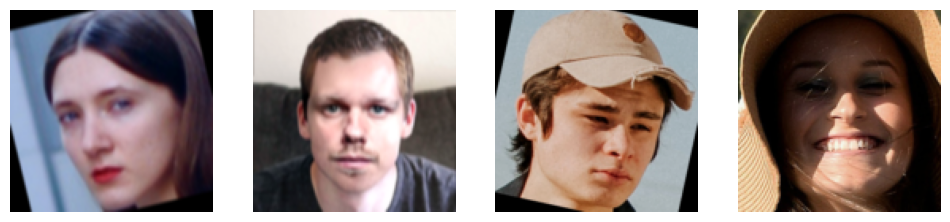

In [60]:
import matplotlib.pyplot as plt
import random

# Function to show images
def show_images(images):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 3))
    for ax, image in zip(axes, images):
        ax.imshow(image.permute(1, 2, 0))  # Permute dimensions for displaying images with matplotlib
        ax.axis('off')
    plt.show()

# Get a batch from the train_loader
for batch in train_loader:
    # Get four random samples from the batch
    random_samples = random.sample(list(batch[0]), 4)

    # Show the images
    show_images(random_samples)

    break  # Break to visualize only one batch


## Taining the augmented data

In [69]:
num_epochs = 30

train_losses = []
avg_train_losses = []
valid_losses = []
avg_valid_losses = []
train_accuracies = []
valid_accuracies = []

for epoch in range(num_epochs):
    training_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        #print(images)
        labels = labels.to(device)
        #print(labels)

        outputs = model2(images)
        #print(outputs)
        loss = criterion(outputs, labels)
        training_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = training_loss / len(train_loader)
    train_losses.append(training_loss)
    avg_train_losses.append(avg_train_loss)

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    model2.eval()
    valid_loss = 0.0
    correct_valid = 0
    total_valid = 0
    with torch.no_grad():
        for images, labels in valid_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model2(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_valid += labels.size(0)
            correct_valid += (predicted == labels).sum().item()

    avg_valid_loss = valid_loss / len(valid_loader)
    valid_losses.append(valid_loss)
    avg_valid_losses.append(avg_valid_loss)

    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}],  Avg Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Avg Valid Loss: {avg_valid_loss:.4f}, Valid Acc: {valid_accuracy:.2f}%')

    model2.train()

print("Entrenamiento finalizado!")

Epoch [1/30],  Avg Train Loss: 0.7458, Train Acc: 51.57%, Avg Valid Loss: 0.6856, Valid Acc: 56.62%
Epoch [2/30],  Avg Train Loss: 0.6922, Train Acc: 52.66%, Avg Valid Loss: 0.6840, Valid Acc: 56.62%
Epoch [3/30],  Avg Train Loss: 0.6921, Train Acc: 52.44%, Avg Valid Loss: 0.6889, Valid Acc: 56.62%
Epoch [4/30],  Avg Train Loss: 0.6926, Train Acc: 52.03%, Avg Valid Loss: 0.6881, Valid Acc: 56.62%
Epoch [5/30],  Avg Train Loss: 0.6901, Train Acc: 55.11%, Avg Valid Loss: 0.6836, Valid Acc: 58.09%
Epoch [6/30],  Avg Train Loss: 0.6811, Train Acc: 57.50%, Avg Valid Loss: 0.6636, Valid Acc: 58.70%
Epoch [7/30],  Avg Train Loss: 0.6685, Train Acc: 59.32%, Avg Valid Loss: 0.6603, Valid Acc: 62.62%
Epoch [8/30],  Avg Train Loss: 0.6609, Train Acc: 60.11%, Avg Valid Loss: 0.6527, Valid Acc: 62.99%
Epoch [9/30],  Avg Train Loss: 0.6504, Train Acc: 61.95%, Avg Valid Loss: 0.6438, Valid Acc: 63.60%
Epoch [10/30],  Avg Train Loss: 0.6486, Train Acc: 62.55%, Avg Valid Loss: 0.8040, Valid Acc: 56.62%

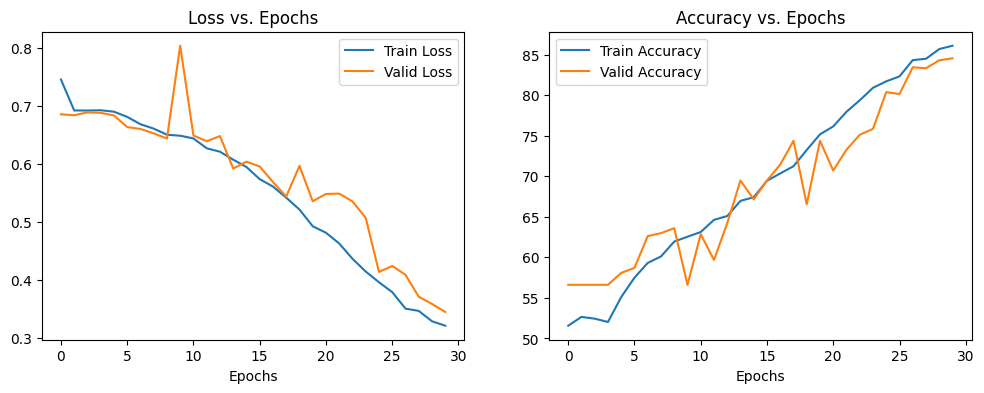

In [70]:
# Graficar el accuracy y el loss

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(avg_train_losses, label='Train Loss')
plt.plot(avg_valid_losses, label='Valid Loss')
plt.legend()
plt.xlabel('Epochs')
plt.title('Loss vs. Epochs')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(valid_accuracies, label='Valid Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.title('Accuracy vs. Epochs')

plt.show()

In [71]:
# Matriz de confusión
import sklearn.metrics as metrics
import numpy as np

y_pred = []
y_true = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model2(inputs)
        _, predicted = torch.max(outputs, 1)
        y_pred.extend(predicted.tolist())
        y_true.extend(labels.tolist())

print('Confusion Matrix')
print(metrics.confusion_matrix(y_true, y_pred))

Confusion Matrix
[[290  89]
 [ 82 356]]
